# 2.2.10 例題: スペースシャトル「チャレンジャー号」の悲劇

In [1]:
using Distributed
addprocs(3)

using CSV
using DataFrames
using HTTP
using LaTeXStrings
using LinearAlgebra
@everywhere using Mamba
using Plots

[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


## データの取得 & 加工

In [2]:
r = HTTP.request("GET", "https://git.io/vXknD");

In [52]:
challengers_data = CSV.read(IOBuffer(r.body))
names!(challengers_data, [:date, :temperature, :incident])
# incidentのパース
challengers_data[:incident] = tryparse.(Int64, challengers_data[:incident])
# NaNを削除
challengers_data = challengers_data[challengers_data[:incident] .!= nothing, :]
challengers_data[:incident] = convert.(Int64, challengers_data[:incident])
disallowmissing!(challengers_data)

23×3 DataFrame
│ Row │ date       │ temperature │ incident │
│     │ String     │ Int64       │ Int64    │
├─────┼────────────┼─────────────┼──────────┤
│ 1   │ 04/12/1981 │ 66          │ 0        │
│ 2   │ 11/12/1981 │ 70          │ 1        │
│ 3   │ 3/22/82    │ 69          │ 0        │
│ 4   │ 01/11/1982 │ 68          │ 0        │
│ 5   │ 04/04/1983 │ 67          │ 0        │
│ 6   │ 6/18/83    │ 72          │ 0        │
│ 7   │ 8/30/83    │ 73          │ 0        │
│ 8   │ 11/28/83   │ 70          │ 0        │
│ 9   │ 02/03/1984 │ 57          │ 1        │
│ 10  │ 04/06/1984 │ 63          │ 1        │
│ 11  │ 8/30/84    │ 70          │ 1        │
│ 12  │ 10/05/1984 │ 78          │ 0        │
│ 13  │ 11/08/1984 │ 67          │ 0        │
│ 14  │ 1/24/85    │ 53          │ 1        │
│ 15  │ 04/12/1985 │ 67          │ 0        │
│ 16  │ 4/29/85    │ 75          │ 0        │
│ 17  │ 6/17/85    │ 70          │ 0        │
│ 18  │ 7/29/85    │ 81          │ 0        │
│ 19  │ 8/27/85    │ 76          │ 0        │
│ 20  │ 10/03/1985 │ 79          │ 0        │
│ 21  │ 10/30/85   │ 75          │ 1        │
│ 22  │ 11/26/85   │ 76          │ 0        │
│ 23  │ 01/12/1986 │ 58          │ 1        │

## データの図示

In [44]:
temperature = challengers_data[:temperature]
color_weight = (temperature .- minimum(temperature)) ./ (maximum(temperature) .- minimum(temperature))
wcolor = weighted_color_mean.(color_weight, colorant"red", colorant"blue")

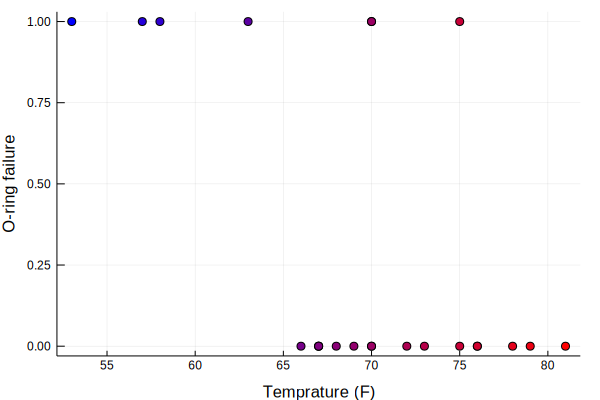

In [45]:
scatter(challengers_data.temperature, challengers_data.incident, 
        markercolor = wcolor, 
        xlabel = "Temprature (F)", ylabel = "O-ring failure", label = "")

## ロジスティック関数を表示する

In [6]:
function logistic(x, alpha, beta)
    1.0 ./ (1.0 .+ exp.(beta * x .+ alpha))
end

logistic (generic function with 1 method)

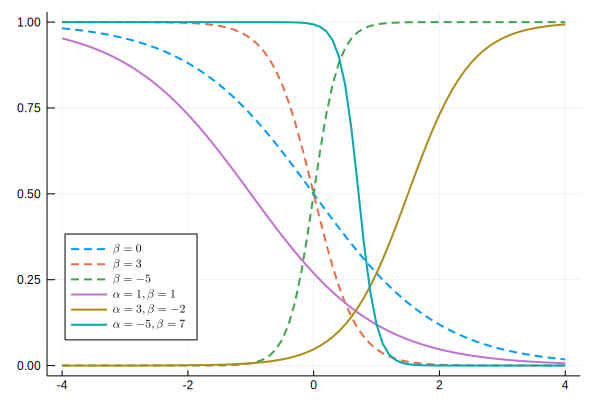

In [7]:
x = -4:0.1:4
Plots.plot(x, logistic.(x, 0, 1), linestyle = :dash, linewidth = 2, label = L"\beta = 0",
    legend = :bottomleft)
Plots.plot!(x, logistic.(x, 0, 3), linestyle = :dash, linewidth = 2, label = L"\beta = 3")
Plots.plot!(x, logistic.(x, 0, -5), linestyle = :dash, linewidth = 2, label = L"\beta = -5")
Plots.plot!(x, logistic.(x, 1, 1), linewidth = 2, label = L"\alpha = 1, \beta = 1")
Plots.plot!(x, logistic.(x, 3, -2), linewidth = 2, label = L"\alpha = 3, \beta = -2")
Plots.plot!(x, logistic.(x, -5, 7), linewidth = 2, label = L"\alpha = -5, \beta = 7")

## チャレンジャー号のモデリング

In [8]:
model = Model(
    
    observed = Stochastic(1,
        p -> UnivariateDistribution[Bernoulli(x) for x in p],
        false
    ),
    
    p = Logical(1,
        (alpha, beta, temperature) -> @.(1.0 / (1.0 + exp(beta * temperature + alpha)))
    ),
    
    alpha = Stochastic(() -> Normal(0, sqrt(1000))),
    beta = Stochastic(() -> Normal(0, sqrt(1000))),

)

Object of type "Model"
-------------------------------------------------------------------------------
alpha:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
p:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
observed:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [9]:
data = Dict{Symbol, Any}(
    :observed => challengers_data[:incident],
    :temperature => challengers_data[:temperature],
)

Dict{Symbol,Any} with 2 entries:
  :temperature => [66, 70, 69, 68, 67, 72, 73, 70, 57, 63  …  53, 67, 75, 70, 8…
  :observed    => [0, 1, 0, 0, 0, 0, 0, 0, 1, 1  …  1, 0, 0, 0, 0, 0, 0, 1, 0, …

In [10]:
inits = [
    Dict{Symbol, Any}(
        :observed => challengers_data[:incident],
        :alpha => 0,
        :beta => 0,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:alpha=>0,:beta=>0,:observed=>[0, 1, 0, 0, 0, 0, 0, 0, 1, 1  …  1, 0, 0, 0, 0, 0, 0, 1, 0, 1])
 Dict(:alpha=>0,:beta=>0,:observed=>[0, 1, 0, 0, 0, 0, 0, 0, 1, 1  …  1, 0, 0, 0, 0, 0, 0, 1, 0, 1])
 Dict(:alpha=>0,:beta=>0,:observed=>[0, 1, 0, 0, 0, 0, 0, 0, 1, 1  …  1, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [11]:
scheme = [AMWG([:alpha, :beta], 0.1)]

1-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:alpha, :beta]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


In [12]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 200000, burnin = 50000, thin = 50, chains = 3)

MCMC Simulation of 200000 Iterations x 3 Chains...

      From worker 3:	Chain 2:   0% [29:05:07 of 29:05:12 remaining]
      From worker 4:	Chain 3:   0% [29:09:37 of 29:09:43 remaining]
      From worker 2:	Chain 1:   0% [29:07:37 of 29:07:42 remaining]
      From worker 4:	Chain 3:  10% [0:01:06 of 0:01:13 remaining]
      From worker 3:	Chain 2:  10% [0:01:06 of 0:01:14 remaining]
      From worker 2:	Chain 1:  10% [0:01:07 of 0:01:14 remaining]
      From worker 4:	Chain 3:  20% [0:00:37 of 0:00:47 remaining]
      From worker 3:	Chain 2:  20% [0:00:38 of 0:00:47 remaining]
      From worker 2:	Chain 1:  20% [0:00:37 of 0:00:47 remaining]
      From worker 4:	Chain 3:  30% [0:00:27 of 0:00:39 remaining]
      From worker 3:	Chain 2:  30% [0:00:28 of 0:00:39 remaining]
      From worker 2:	Chain 1:  30% [0:00:28 of 0:00:39 remaining]
      From worker 4:	Chain 3:  40% [0:00:21 of 0:00:35 remaining]
      From worker 2:	Chain 1:  40% [0:00:21 of 0:00:35 remaining]
      From worker 

Object of type "ModelChains"

Iterations = 50050:200000
Thinning interval = 50
Chains = 1,2,3
Samples per chain = 3000

[0.240476 -15.5617 … 0.0621262 0.833982; 0.232638 -16.1149 … 0.172841 0.932255; … ; 0.197054 -12.8265 … 0.104369 0.801768; 0.198023 -12.7957 … 0.095004 0.78758]

[0.169935 -11.9486 … 0.275587 0.890159; 0.176738 -12.1373 … 0.215044 0.868355; … ; 0.397908 -27.5182 … 0.0616428 0.988337; 0.433178 -28.3444 … 0.0101801 0.961584]

[0.259883 -16.8565 … 0.0524182 0.856097; 0.240834 -16.0718 … 0.0969566 0.891243; … ; 0.376767 -24.7607 … 0.0203592 0.948248; 0.309488 -21.258 … 0.0942278 0.964692]

In [13]:
describe(sim)

Iterations = 50050:200000
Thinning interval = 50
Chains = 1,2,3
Samples per chain = 3000

Empirical Posterior Estimates:
           Mean          SD        Naive SE       MCSE         ESS   
 beta   0.269080243 0.110923419 0.00116923550 0.0082788716  179.51643
alpha -17.484526608 7.545245244 0.07953386825 0.5636181458  179.21600
 p[1]   0.436947936 0.140055119 0.00147631058 0.0042148816 1104.14784
 p[2]   0.223169365 0.100383755 0.00105813768 0.0025576253 1540.46926
 p[3]   0.268291719 0.108480123 0.00114348089 0.0016592438 3000.00000
 p[4]   0.319845838 0.117970778 0.00124352119 0.0012955837 3000.00000
 p[5]   0.376715411 0.128760972 0.00135725981 0.0024766695 2702.91488
 p[6]   0.152695673 0.087098520 0.00091809901 0.0037089877  551.45587
 p[7]   0.126300826 0.081329985 0.00085729332 0.0039348057  427.22317
 p[8]   0.223169365 0.100383755 0.00105813768 0.0025576253 1540.46926
 p[9]   0.839583065 0.149422494 0.00157505138 0.0098961635  227.98078
p[10]   0.613675448 0.164226570 0.00173

In [14]:
gelmandiag(sim, mpsrf = true, transform = true)

              PSRF 97.5%
        beta 1.025 1.075
       alpha 1.026 1.075
        p[1] 1.003 1.012
        p[2] 1.002 1.006
        p[3] 1.000 1.001
        p[4] 1.000 1.000
        p[5] 1.001 1.004
        p[6] 1.006 1.021
        p[7] 1.009 1.029
        p[8] 1.002 1.006
        p[9] 1.022 1.065
       p[10] 1.012 1.039
       p[11] 1.002 1.006
       p[12] 1.017 1.052
       p[13] 1.001 1.004
       p[14] 1.023 1.070
       p[15] 1.001 1.004
       p[16] 1.013 1.041
       p[17] 1.002 1.006
       p[18] 1.019 1.059
       p[19] 1.015 1.045
       p[20] 1.018 1.055
       p[21] 1.013 1.041
       p[22] 1.015 1.045
       p[23] 1.021 1.063
Multivariate   NaN   NaN



## 事後分布の確認

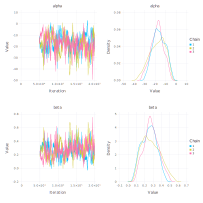

In [15]:
p = Mamba.plot(sim[:, [:alpha, :beta], :], legend = true)
Mamba.draw(p, nrow = 2, ncol = 2)

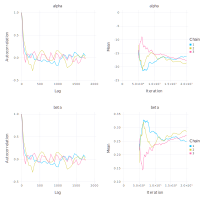

In [16]:
p = Mamba.plot(sim[:, [:alpha, :beta], :], [:autocor, :mean], legend=true)
Mamba.draw(p, nrow = 2, ncol = 2)

In [17]:
alpha_samples = sim[:, [:alpha], :].value[:]
beta_samples = sim[:, [:beta], :].value[:]

9000-element Array{Float64,1}:
 0.2404756026345599 
 0.23263788150176917
 0.23240172599464676
 0.23423144912611932
 0.23788910206426214
 0.25168347161618754
 0.2274622363831013 
 0.18946391000667612
 0.219098542662778  
 0.21987390266678578
 0.23676057537612677
 0.2304324901548956 
 0.24505942232920838
 ⋮                  
 0.2079248536146508 
 0.3065291320107197 
 0.254934477272867  
 0.3123642531368256 
 0.32646374989249377
 0.2840093526632366 
 0.3597566373212401 
 0.3552238264445272 
 0.34898747849080525
 0.36067626993522217
 0.37676716123660714
 0.30948772910013733

## (演習問題) $\alpha$に対して$\beta$をプロットする

In [18]:
scatter(alpha_samples, beta_samples, label = "", markersize = 3)

## 破損確率の事後期待値と、サンプルの中から二つ選んでプロットする

In [19]:
xs = collect((minimum(temperature) - 5):0.1:(maximum(temperature) + 5))
p_t = logistic(transpose(xs), alpha_samples, beta_samples)

9000×381 Array{Float64,2}:
 0.982344  0.981922  0.98149   0.981048  …  0.00608905   0.00594523 
 0.992954  0.992789  0.992621  0.992449     0.0204574    0.0199964  
 0.957479  0.956523  0.955546  0.954548     0.00335575   0.00327892 
 0.970882  0.970213  0.969528  0.968829     0.0046302    0.0045235  
 0.963645  0.962802  0.961941  0.96106      0.00320892   0.00313372 
 0.963169  0.962266  0.961341  0.960395  …  0.00187942   0.0018328  
 0.989702  0.989468  0.989228  0.988983     0.0170341    0.0166574  
 0.959401  0.958657  0.957899  0.957128     0.017669     0.0173432  
 0.943925  0.942754  0.94156   0.940343     0.00415006   0.00406049 
 0.980287  0.979858  0.979419  0.978971     0.0118132    0.0115592  
 0.978509  0.978005  0.97749   0.976963  …  0.00573832   0.0056048  
 0.974404  0.973823  0.97323   0.972623     0.00609614   0.00595809 
 0.975919  0.975337  0.97474   0.97413      0.00373679   0.00364666 
 ⋮                                       ⋱               ⋮          
 0.9821

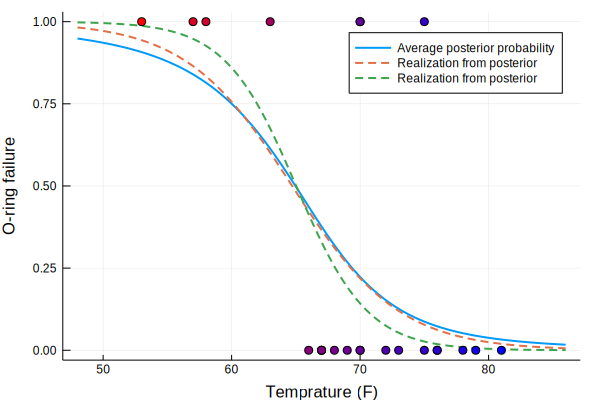

In [20]:
Plots.plot(xs, vec(mean(p_t, dims=1)), linewidth = 2, label = "Average posterior probability")
Plots.plot!(xs, p_t[1, :], linewidth = 2, linestyle = :dash, label = "Realization from posterior")
Plots.plot!(xs, p_t[end-2, :], linewidth = 2, linestyle = :dash, label = "Realization from posterior")
scatter!(challengers_data.temperature, challengers_data.incident, 
        markercolor = weighted_color_mean.(color_weight, colorant"blue", colorant"red"), 
        xlabel = "Temprature (F)", ylabel = "O-ring failure", label = "")

## 破損確率の事後期待値と、95%信頼区間をプロットする

In [21]:
p_t_ci = mapslices(x -> quantile(x, [0.025, 0.975]), p_t, dims = 1)

2×381 Array{Float64,2}:
 0.632772  0.630838  0.628897  …  4.01806e-5  3.80981e-5  3.62019e-5
 0.999919  0.999915  0.99991      0.118088    0.117092    0.116443  

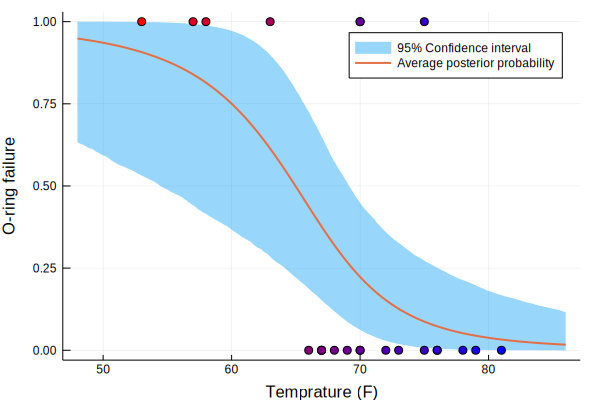

In [22]:
Plots.plot(xs, p_t_ci[2, :], linewidth = 0, 
    fillrange = p_t_ci[1, :], fillalpha = 0.4,
    label = "95% Confidence interval")
Plots.plot!(xs, vec(mean(p_t, dims=1)), linewidth = 2, label = "Average posterior probability")
scatter!(challengers_data.temperature, challengers_data.incident, 
        markercolor = weighted_color_mean.(color_weight, colorant"blue", colorant"red"), 
        xlabel = "Temprature (F)", ylabel = "O-ring failure", label = "")

## チャレンジャー号の悲劇の日に何が起こった？

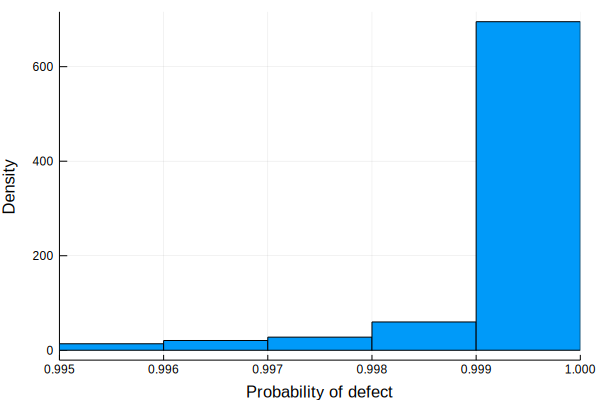

In [23]:
prob_31 = logistic(31, alpha_samples, beta_samples)
histogram(prob_31, bins = 1000, xlim = (0.995, 1), 
            normalize = :pdf, 
            xlabel = "Probability of defect ", ylabel = "Density", label = "")

## このモデルは適切か？
データセットをシミュレーション生成する

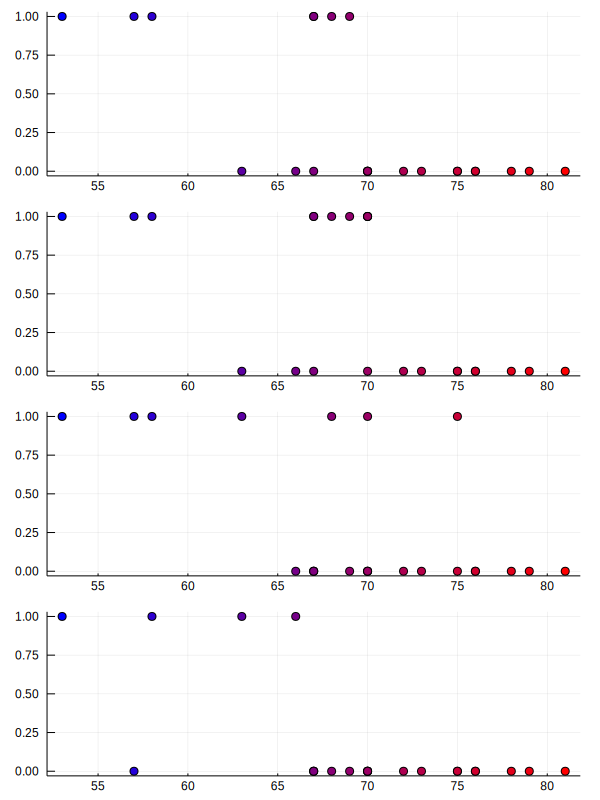

In [46]:
plts = []
for i in 0:3
    push!(plts, 
        scatter(temperature, rand.(Bernoulli.(vec(sim[end, :p, 1].value))), 
            markercolor = wcolor, label = "")
    )
end
Plots.plot(plts..., layout = (4, 1), size = [600, 800])

## セパレーションプロット

In [137]:
N = length(challengers_data[:incident])

23

In [147]:
function sep_plot(prob)
    ix = sortperm(prob)
    N = length(prob)
    xxs = vec(transpose(hcat(0:N-1, 1:N)))
    yys = vec(transpose(repeat(prob[ix], 1, 2)))
    incident_index = findall(x -> x == 1, challengers_data[:incident][ix])
    incident_bar = vec(transpose(hcat(incident_index .- 1, incident_index)))
    vspan(incident_bar, fillcolor = :black, linecolor =:transparent, fillalpha = 0.15, label = "")
    vline!([N - length(incident_index)], linewidth = 2, label = "")
    Plots.plot!(xxs, yys, linewidth = 2, label = "", ylim = (0, 1))
end

sep_plot (generic function with 1 method)

### ベイズ的気温依存モデル

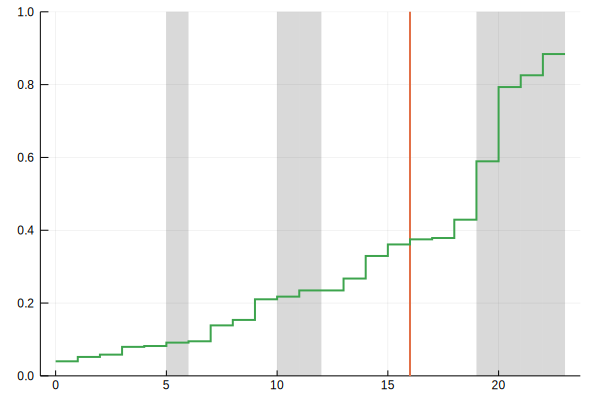

In [148]:
prob_defect = vec(mean(rand.(Bernoulli.(sim[:, :p, 1].value)), dims = 1))
sep_plot(prob_defect)

### 完全モデル

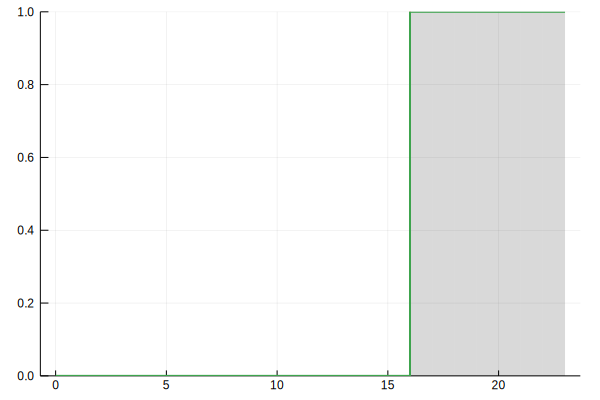

In [149]:
sep_plot(challengers_data[:incident])

### ランダムモデル

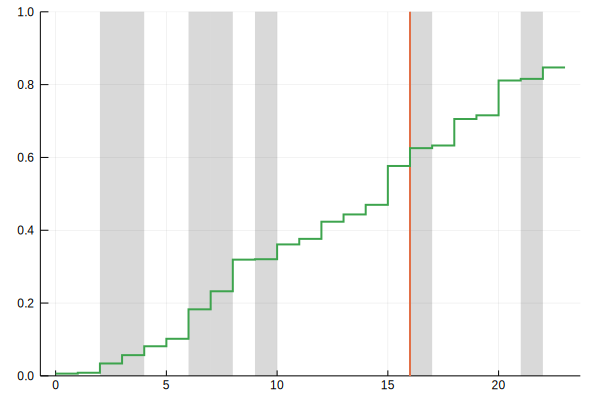

In [150]:
sep_plot(rand(N))

### 定数モデル

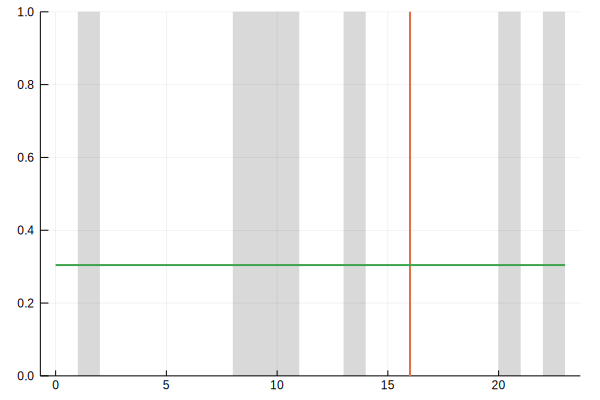

In [151]:
sep_plot(fill(7 ./ N, N))